# Treść zadania

Problem **czytelników i pisarzy** proszę rozwiązać przy pomocy semaforów i zmiennych warunkowych.

Proszę wykonać pomiary dla różnej ilości czytelników (10-100) i pisarzy (od 1 do 10).

W sprawozdaniu proszę narysować 3D wykres czasu w zależności od liczby wątków i go zinterpretować.

## Blokowanie drobnoziarniste

**Zamek (lock)** jest przydatny wtedy, gdy operacje zamykania/otwierania nie mogą być umieszczone w jednej metodzie lub bloku
*synchronized*. Przykładem jest zakładanie blokady (lock) na elementy struktury danych, np. listy. Podczas przeglądania listy stosujemy następujący algorytm:

1. Zamknij zamek na pierwszym elemencie listy
2. Zamknij zamek na drugim elemencie
3. Otwórz zamek na pierwszym elemencie
4. Zamknij zamek na trzecim elemencie
5. Otwórz zamek na drugim elemencie
6. Powtarzaj dla kolejnych elementów

Dzięki temu unikamy konieczności blokowania całej listy i wiele wątków może równocześnie przeglądać i modyfikować różne jej
fragmenty.

## Ćwiczenie

1. Proszę zaimplementować listę, w której każdy węzeł składa się z wartości typu Object, referencji do następnego węzła
   oraz zamka (lock)

2. Proszę zastosować metodę drobnoziarnistego blokowania do następujących metod listy:

   ```java
   boolean contains(Object o); // czy lista zawiera element o
   boolean remove(Object o); // usuwa pierwsze wystąpienie elementu o
   boolean add(Object o); // dodaje element o na końcu listy  
   ```

Proszę porównać wydajność tego rozwiązania w stosunku do listy z jednym zamkiem blokującym dostęp do całości.

# Rozwiązania

**Problem czytelników i pisarzy** – klasyczny informatyczny problem synchronizacji dostępu do jednego zasobu
(pliku, rekordu bazy danych) dwóch rodzajów procesów: dokonujących i niedokonujących w nim zmian.

W problemie czytelników i pisarzy zasób jest dzielony przez dwie grupy procesów:

- **czytelnicy** – wszystkie procesy niedokonujące zmian w zasobie,
- **pisarze** – pozostałe procesy.

Jednoczesny dostęp do zasobu może uzyskać dowolna liczba czytelników. Pisarz może otrzymać tylko dostęp wyłączny.
Równocześnie z pisarzem dostępu do zasobu nie może otrzymać ani inny pisarz, ani czytelnik, gdyż mogłoby to spowodować błędy.

W trakcie wykonania tego laboratorium powstała następująca struktura:

```
tw-lab6/src/main/java/pl/edu/agh/tw/knapp/lab6
    blocking
        BlockingDatabaseCondDriver.java
        BlockingDatabaseDriver.java
        SimpleDatabase.java
    DatabaseDriver.java
    Database.java
    finegrained
        Box.java
        FineGrainedDatabaseDriver.java
        FineGrainedDatabase.java
    Logger.java
    Main.java
    RandomSleeper.java
    worker
        factory
            ReaderFactory.java
            WorkerFactory.java
            WriterFactory.java
        Reader.java
        thread
            ReaderThread.java
            WorkerThread.java
            WriterThread.java
        Worker.java
        Writer.java
```

Poszczególne pakiety, klasy i rozwiązania zostaną opisane poniżej.

Łącznie powstało 3 rozwiązania:

1. Rozwiązanie z jednym zamkiem zaimplementowane korzystając z semaforów (pakiet `blocking`)
2. Rozwiązanie z jednym zamkiem zaimplementowane korzystając ze zmiennych warunkowych (pakiet `blocking`)
3. Rozwiązanie zaimplementowane w oparciu o blokowanie drobnoziarniste (pakiet `finegrained`)

Wszystkie 3 rozwiązania symulują dostęp do bazy danych.

## Pakiety

- `blocking`: zawiera rozwiązania z jednym zamkiem
- `finegrained`: zawiera rozwiązanie z blokowaniem drobnoziarnistym
- `worker`: zawiera interfejsy czytelników i pisarzy (wspólna nazwa: pracownicy, workers)
  - `factory`: zawiera fabryki produkujące pracowników. Fabryka posiada metodę `get`, która akceptuje wartość
    typu `int` - numer iteracji; zwraca implementację pracownika (czytelnika, pisarza). Fabryki są potrzebne w celu
    umożliwienia czytelnego logowania (żeby pracownik miał dostęp do numeru iteracji)
  - `thread`: zawiera implementacje wątków czytelników i pisarzy

## Klasy

### `Database<T>`

Jest to interfejs reprezentujący bazę danych. Posiada metody służące do modyfikowania i iterowania po bazie danych.

```java
// Database.java

package pl.edu.agh.tw.knapp.lab6;

import java.util.function.Consumer;

public interface Database<T> {
    <E extends T> boolean contains(E element);
    <E extends T> boolean remove(E element);
    <E extends T> boolean add(E element);
    void forEach(Consumer<? super T> consumer);
}
```

### `DatabaseDriver<T>`

Klasa abstrakcyjna, jest klasą nadrzędną dla pozostałych driverów. Zarządza\* dostępem do bazy danych.

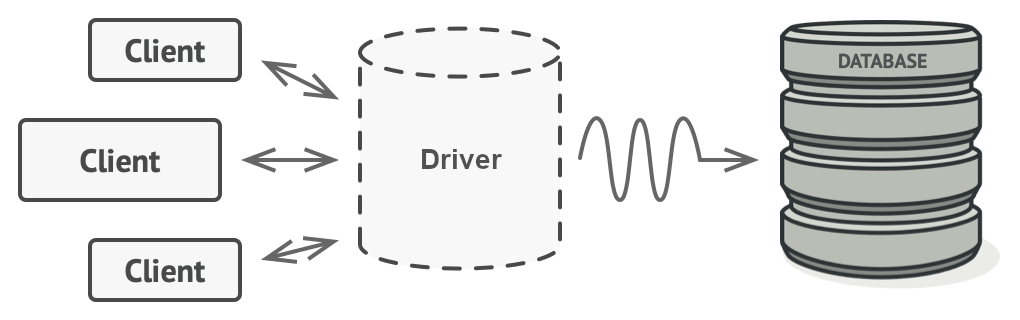

```java
// DatabaseDriver.java

package pl.edu.agh.tw.knapp.lab6;

import pl.edu.agh.tw.knapp.lab6.worker.Reader;
import pl.edu.agh.tw.knapp.lab6.worker.Writer;

public abstract class DatabaseDriver<T> {
    private final static Logger logger = Logger.getInstance();

    public abstract boolean read(Reader<T> reader);
    public abstract boolean write(Writer<T> writer);

    protected void logException(Exception e) {
        logger.log(getClass().getSimpleName(),
            "Exception: " + e.getMessage() + "\n" + e);
    }
}
```

*\* – np. stosuje pewne mechanizmy synchronizacji dostępu do bazy danych*

### `Worker<T>`, `Reader<T>`, `Writer<T>`

Są to interfejsy reprezentujące odpowiednio pracownika, czytelnika i pisarza.

Implementacja wygląda następująco:

```java
// Worker.java

package pl.edu.agh.tw.knapp.lab6.worker;

import pl.edu.agh.tw.knapp.lab6.Database;

public interface Worker<T> {
    void work(Database<T> db);
}
```

```java
// Reader.java

package pl.edu.agh.tw.knapp.lab6.worker;

import pl.edu.agh.tw.knapp.lab6.Database;

public interface Reader<T> extends Worker<T> {
    default void read(Database<T> db) {
        work(db);
    }
}
```

```java
// Writer.java

package pl.edu.agh.tw.knapp.lab6.worker;

import pl.edu.agh.tw.knapp.lab6.Database;

public interface Writer<T> extends Worker<T> {
    default void write(Database<T> db) {
        work(db);
    }
}
```

### `WorkerFactory<T>`, `ReaderFactory<T>`, `WriterFactory<T>`

Są to interfejsy reprezentujące fabryki odpowiednio pracownika, czytelnika i pisarza.
Jak już zostało wspomniane wcześniej, fabruki są po to, żeby pracownik miał dostęp do numeru iteracji
pochodzącego z odpowiedniego wątku (`WorkerThread`), co z kolei pozwala podnieść czytelność logów.

Implementacja wygląda następująco:

```java
// WorkerFactory.java

package pl.edu.agh.tw.knapp.lab6.worker.factory;

import pl.edu.agh.tw.knapp.lab6.worker.Worker;

public interface WorkerFactory<T> {
    Worker<T> get(int iteration);
}
```

```java
// ReaderFactory.java

package pl.edu.agh.tw.knapp.lab6.worker.factory;

import pl.edu.agh.tw.knapp.lab6.worker.Reader;

public interface ReaderFactory<T> extends WorkerFactory<T> {
    @Override
    Reader<T> get(int iteration);
}
```

```java
// WriterFactory.java

package pl.edu.agh.tw.knapp.lab6.worker.factory;

import pl.edu.agh.tw.knapp.lab6.worker.Writer;

public interface WriterFactory<T> extends WorkerFactory<T> {
    @Override
    Writer<T> get(int iteration);
}
```

### `WorkerThread<T>`, `ReaderThread<T>`, `WriterThread<T>`

`WorkerThread` jest to abstrakcyjna klasa nadrzędna, reprezentująca wątek pracownika. Wykonuje zadaną
liczbę iteracji, po każdej iteracji wątek zostaje uśpiony na pewien czas, losowany z zadanego przedziału.
Posiada metodę abstrakcyjną `void onIter(int i)`, która jest wywoływana co każdą iterację, `i` - numer
tej iteracji.

`ReaderThread` i `WriterThread` dziedziczą po klasie `WorkerThread` i implementują metodę `onIter`.

Implementacje wszystkich trzech klas wyglądają następująco:

```java
// WorkerThread.java

package pl.edu.agh.tw.knapp.lab6.worker.thread;

import pl.edu.agh.tw.knapp.lab6.DatabaseDriver;
import pl.edu.agh.tw.knapp.lab6.RandomSleeper;
import pl.edu.agh.tw.knapp.lab6.worker.factory.WorkerFactory;

public abstract class WorkerThread<T> extends Thread {
    protected final WorkerFactory<T> factory;
    protected final DatabaseDriver<T> driver;
    private final RandomSleeper sleeper;
    private final int iterCount;

    public WorkerThread(WorkerFactory<T> factory, DatabaseDriver<T> driver,
                        int delayMinMs, int delayMaxMs, int iterCount)
    {
        this.factory = factory;
        this.driver = driver;
        this.sleeper = new RandomSleeper(delayMinMs, delayMaxMs);
        this.iterCount = iterCount;
    }

    @Override
    public void run() {
        for (int i = 0; i < iterCount; ++i) {
            onIter(i);

            try {
                sleeper.sleep();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }
    }

    protected abstract void onIter(int i);
}
```

```java
// ReaderThread.java

package pl.edu.agh.tw.knapp.lab6.worker.thread;

import pl.edu.agh.tw.knapp.lab6.DatabaseDriver;
import pl.edu.agh.tw.knapp.lab6.worker.Reader;
import pl.edu.agh.tw.knapp.lab6.worker.factory.ReaderFactory;

public class ReaderThread<T> extends WorkerThread<T> {
    public ReaderThread(ReaderFactory<T> factory, DatabaseDriver<T> driver,
                        int delayMinMs, int delayMaxMs, int iterCount)
    {
        super(factory, driver, delayMinMs, delayMaxMs, iterCount);
    }

    @Override
    protected void onIter(int i) {
        driver.read((Reader<T>) factory.get(i));
    }
}
```

```java
// WriterThread.java

package pl.edu.agh.tw.knapp.lab6.worker.thread;

import pl.edu.agh.tw.knapp.lab6.DatabaseDriver;
import pl.edu.agh.tw.knapp.lab6.worker.Writer;
import pl.edu.agh.tw.knapp.lab6.worker.factory.WriterFactory;

public class WriterThread<T> extends WorkerThread<T> {
    public WriterThread(WriterFactory<T> factory, DatabaseDriver<T> driver,
                        int delayMinMs, int delayMaxMs, int iterCount)
    {
        super(factory, driver, delayMinMs, delayMaxMs, iterCount);
    }

    @Override
    protected void onIter(int i) {
        driver.write((Writer<T>) factory.get(i));
    }
}
```

### `Logger`

Jest to klasa służąca do tworzenia logów. Podczas implementacji, w celach ułatwienia zarządzaniem logami,
użyto wzorca *Singleton*.

```java
// Logger.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.function.Consumer;

public class Logger {
    private static final Logger logger = new Logger();

    private Consumer<String> consumer = defaultConsumer();

    private static Consumer<String> defaultConsumer() {
        return System.out::println;
    }

    private Logger() {
        // empty
    }

    public void log(String tag, Object o) {
        consumer.accept(String.format("[%s] %s", tag, o));
    }

    public void log(Object o) {
        consumer.accept(String.valueOf(o));
    }

    public void setConsumer(Consumer<String> consumer) {
        this.consumer = consumer;
    }

    public void mute() {
        setConsumer(s -> {});
    }

    public void unmute() {
        setConsumer(defaultConsumer());
    }

    public static Logger getInstance() {
        return logger;
    }
}
```

Jak i w przypadku poprzedniego laboratorium,

- `log(String tag, Object o)` wypisuje log wraz z tagiem (np. *Philosopher #5*. Chodzi tu o
  rozpoznawanie źródła pochodzenia informacji). Obiekt `o` może mieć wartość `null`.
- `log(Object o)` wypisuje tekstową reprezentację obiektu `o`. Obiekt `o` może mieć wartość `null`.
- `setConsumer(Consumer<String> consumer)` umożliwia ustawienie kastomowego konsumenta logów
- `mute()` wycisza Logger
- `unmute()` przeciwieństwo metody `mute`: jako konsument zostanie użyta domyślna implementacja wypisująca
  na standardowym wyjściu
- `getInstance()` zwraca instancję klasy `Logger`

### `RandomSleeper`

Klasa służąca do uśpienia wątku na pewien czas, losowany z przedziału `[delayMinMs, delayMaxMs)`.

```java
// RandomSleeper.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.Random;

public class RandomSleeper {
    private final Random delayRandom = new Random();
    private final long delayMinMs;
    private final long delayMaxMs;

    public RandomSleeper(long delayMinMs, long delayMaxMs) {
        this.delayMinMs = delayMinMs;
        this.delayMaxMs = delayMaxMs;
    }

    public void sleep() throws InterruptedException {
        if (delayMinMs == 0 && delayMaxMs == 0)
            return;
        var delay = delayRandom.nextLong(delayMinMs, delayMaxMs);
        Thread.sleep(delay);
    }
}
```

## Rozwiązania z jednym zamkiem

W tym rozdziale zostaną zaprezentowane i opisane 2 rozwiązania z jednym zamkiem: zaimplementowane
w oparciu o semafory i zmienne warunkowe.

### `SimpleDatabase<T>`

Jest to klasa implementująca interfejs `Database`. W tym przypadku jest to zwykły wrapper dla listy
typu `LinkedList<T>`.

Implementacja wygląda w następujący sposób:

```java
// SimpleDatabase.java

package pl.edu.agh.tw.knapp.lab6.blocking;

import pl.edu.agh.tw.knapp.lab6.Database;

import java.util.LinkedList;
import java.util.List;
import java.util.function.Consumer;

public class SimpleDatabase<T> implements Database<T> {
    private final List<T> data = new LinkedList<>();

    @Override
    public <E extends T> boolean contains(E element) {
        return data.contains(element);
    }

    @Override
    public <E extends T> boolean remove(E element) {
        return data.remove(element);
    }

    @Override
    public <E extends T> boolean add(E element) {
        return data.add(element);
    }

    @Override
    public void forEach(Consumer<? super T> consumer) {
        data.forEach(consumer);
    }
}
```

### `BlockingDatabaseDriver<T>`

Jest to driver reprezentujący rozwiązanie z wykorzystaniem semaforów. Dziedziczy po `DatabaseDriver`.

Zostały użyte 3 semafory o wartości początkowej `1`:

1. `resource`: służy do zarządzania dostępem do zasobu (bazy danych)
2. `readCountLock`: służy do zsynchronizowanego dostępu do licznika aktywnych czytelników
3. `serviceQueue`: służy do kolejkowania pracowników (jest do możliwe dzieki temu, że semafory
   w Javie mogą się zachowywać jak kolejki FIFO\*). Właśnie dzieki temu semaforowi nie zostanie
   zagłodzona żadna kategoria pracowników.

*\* – dokładniej mówiąc, ten semafor został stworzony w sposób, gwarantujący kolejność FIFO.*

**Opis algorytmu:**

- Każdy pracownik najpierw "wchodzi do kolejki" blokując `serviceQueue`
- Jeżeli to jest pisarz, to:
  - Blokuje semafor `resource`
  - Odblokowuje `serviceQueue`
  - Pisze do bazy danych
  - Odblokowuje `resource`
- Jeżeli to jest czytelnik, to sprawa trochę bardziej się komplikuje:
  - Blokuje `serviceQueue`
  - Blokuje `readCountLock`
  - Zwiększa licznik `readCount` o `1`
  - Jeżeli `readCount == 1`, to blokuje `resource`. To znaczy, że ten czytelnik "wchodzi do pustej sali"
  - Odblokowuje `serviceQueue`
  - Odblokowuje `readCountLock`
  - Czyta z bazy danych
  - Blokuje `readCountLock`
  - Zmniejsza licznik `readCount` o `1`
  - Jeżeli `readCount == 0`, to odblokowuje `resource`. To znaczy, że "wychodzi z sali jako ostatni"
  - Odblokowuje `readCountLock`

Jak już zostało wspomniane wcześniej, `serviceQueue` zachowuje się jak kolejka `FIFO`.
Zgodnie z dokumentacją, został użyty następujący konstruktor z wartością `fair` ustawioną na `true`:

> ```java
> public Semaphore(int permits, boolean fair)
> ```
> 
> Creates a Semaphore with the given number of permits and the given fairness setting.
>
> Parameters:
> 
> - **`permits`** - the initial number of permits available. This value may be negative, in
>   which case releases must occur before any acquires will be granted.
> - **`fair`** - `true` if this semaphore will guarantee first-in first-out granting of permits
>   under contention, else `false`

Implementacja wygląda następująco:

```java
// BlockingDatabaseDriver.java

package pl.edu.agh.tw.knapp.lab6.blocking;

import pl.edu.agh.tw.knapp.lab6.*;
import pl.edu.agh.tw.knapp.lab6.worker.Reader;
import pl.edu.agh.tw.knapp.lab6.worker.Writer;

import java.util.concurrent.Semaphore;

public class BlockingDatabaseDriver<T> extends DatabaseDriver<T> {
    private final Database<T> database = new SimpleDatabase<>();

    // controls access (read/write) to the resource
    private final Semaphore resource = new Semaphore(1);

    // for syncing changes to shared variable readcount
    private final Semaphore readCountLock = new Semaphore(1);

    // FAIRNESS: preserves ordering of requests
    private final Semaphore serviceQueue = new Semaphore(1, true);

    private int readCount = 0;

    @Override
    public boolean read(Reader<T> reader) {
        try {
            readImpl(reader);
            return true;
        } catch (InterruptedException e) {
            logException(e);
            return false;
        }
    }

    @Override
    public boolean write(Writer<T> writer) {
        try {
            writeImpl(writer);
            return true;
        } catch (InterruptedException e) {
            logException(e);
            return false;
        }
    }

    private void readImpl(Reader<T> reader) throws InterruptedException {
        serviceQueue.acquire();     // wait in line to be serviced
        readCountLock.acquire();    // request exclusive access to readCount

        readCount++; // update count of active readers

        if (readCount == 1)     // if I am the first reader
            resource.acquire(); // request resource access for readers (writers blocked)

        serviceQueue.release();     // let next in line be serviced
        readCountLock.release();    // release access to readCount

        // critical section: perform reading
        reader.read(database);

        readCountLock.acquire(); // request exclusive access to readCount

        readCount--; // update count of active readers

        if (readCount == 0)     // if there are no readers left
            resource.release(); // release resource access for all

        readCountLock.release(); // release access to readCount
    }

    private void writeImpl(Writer<T> writer) throws InterruptedException {
        serviceQueue.acquire(); // wait in line to be serviced
        resource.acquire();     // request exclusive access to resource
        serviceQueue.release(); // let next in line be serviced

        // critical section: perform writing
        writer.write(database);

        resource.release();      // release resource access for next reader/writer
    }
}
```

### `BlockingDatabaseCondDriver<T>`

Jest to driver reprezentujący rozwiązanie z wykorzystaniem zmiennych warunkowych.
Dziedziczy po `DatabaseDriver`.

W implementacji użyto następujących mechanizmów synchronizujących:

1. `ReentrantLock lock`: z tego zamku tworzy się zmienna warunkowa, służy do synchronizacji dostępu
   do zmiennej `readCount`. Zamek ten zachowuje się jak kolejka FIFO.
2. `Condition cond`: jest to zmienna warunkowa, służąca do śledzenia zmian zmiennej `readCount`

**Opis algorytmu:**

- Każdy pracownik najpierw "wchodzi do kolejki" blokując `lock`
- Pisarz:
  - Jeżeli liczba czytelników (`readCount`) nie jest równa `0` - czeka
  - Ustawia liczbę czytelników równą `-1`
  - Odblokowuje `lock`
  - Zapisuje do bazy danych
  - Blokuje `lock`
  - Ustawia liczbę czytelników równą `0`
  - Powiadamia wszystkich oczekujących
  - Odblokowuje `lock`
- Czytelnik:
  - Jeżeli liczba czytelników jest mniejsza niż `0` - czeka
  - Zwiększa `readCount` o `1`
  - Odblokowuje `lock`
  - Czyta z bazy danych
  - Blokuje `lock`
  - Zmniejsza `readCount` o `1`
  - Jeżeli `readCount == 0` - powiadamia wszystkich
  - Odblokowuje `lock`

Jak już zostało wspomniane wcześniej, zamek `lock` zachowuje się jak kolejka `FIFO`.
Zgodnie z dokumentacją, został użyty następujący konstruktor z wartością `fair` ustawioną na `true`:

> ```java
> public ReentrantLock(boolean fair)
> ```
>
> Creates an instance of ReentrantLock with the given fairness policy.
>
> Parameters:
>
> - **`fair`** - `true` if this lock should use a fair ordering policy

Implementacja wygląda następująco:

```java
// BlockingDatabaseCondDriver.java

package pl.edu.agh.tw.knapp.lab6.blocking;

import pl.edu.agh.tw.knapp.lab6.Database;
import pl.edu.agh.tw.knapp.lab6.DatabaseDriver;
import pl.edu.agh.tw.knapp.lab6.worker.Reader;
import pl.edu.agh.tw.knapp.lab6.worker.Writer;

import java.util.concurrent.locks.Condition;
import java.util.concurrent.locks.Lock;
import java.util.concurrent.locks.ReentrantLock;

public class BlockingDatabaseCondDriver<T> extends DatabaseDriver<T> {
    private final Database<T> database = new SimpleDatabase<>();

    private final Lock lock = new ReentrantLock(true);
    private final Condition cond = lock.newCondition();

    int readCount = 0;

    @Override
    public boolean read(Reader<T> reader) {
        lock.lock();

        try {
            while (readCount < 0)
                cond.await();
            ++readCount;
        } catch (InterruptedException e) {
            logException(e);
            return false;
        } finally {
            lock.unlock();
        }

        // critical section: read
        reader.read(database);

        lock.lock();

        --readCount;

        if (readCount == 0)
            cond.signalAll();

        lock.unlock();

        return true;
    }

    @Override
    public boolean write(Writer<T> writer) {
        lock.lock();

        try {
            while (readCount != 0)
                cond.await();
            readCount = -1;
        } catch (InterruptedException e) {
            logException(e);
            return false;
        } finally {
            lock.unlock();
        }

        // critical section: write
        writer.write(database);

        lock.lock();
        readCount = 0;
        cond.signalAll();
        lock.unlock();

        return true;
    }
}
```

## Rozwiązanie z wykorzystaniem blokowania drobnoziarnistego

**Blokowanie drobnoziarniste** (ang. **fine-grained locking**) pozwala osiągnąc maksymalną równoległość blokując
tylko niezbędne fragmenty danych i odblokowując możliwie jak najszybciej. Dzięki temu unikamy konieczności blokowania
całej listy i wiele wątków może równocześnie przeglądać i modyfikować różne jej fragmenty.

To rozwiązanie zostało zaimplementowane dla obu kategorii pracowników: czytelników i pisarzy. Tylko jeden pisarz
może modyfikować pojedynczy węzeł (node, element listy) naraz, wtedy jak kilka czytelników mogą jednocześnie odczytywać
wartość węzła.

### `FineGrainedDatabase<T>`

W przypadku blokowania drobnoziarnistego, wszystkie mechanizmy synchronizujące znajdują się w bazie danych,
a nie w driverze.

W implementacji zostały użyte 3 semafory o wartości początkowej `1`, które zachowują się tak samo jak w przypadku
`BlockingDatabaseDriver<T>`.

Idea algorytmu została opisana w treści zadania.

Implementacja wygląda następująco:

```java
// FineGrainedDatabase.java

package pl.edu.agh.tw.knapp.lab6.finegrained;

import pl.edu.agh.tw.knapp.lab6.Database;

import java.util.concurrent.Semaphore;
import java.util.function.Consumer;
import java.util.function.Function;

public class FineGrainedDatabase<T> implements Database<T> {
    private final Node head = new Node();

    public FineGrainedDatabase() {
        // empty
    }

    @Override
    public <E extends T> boolean contains(E element) {
        var isContains = new Box<>(false);

        forEach(value -> {
            if (isEqual(value, element)) {
                isContains.setValue(true);
                return false;
            }

            return true;
        });

        return isContains.getValue();
    }

    @Override
    public <E extends T> boolean remove(E element) {
        try {
            boolean isRemoved = false;

            Node prev = head;
            prev.writeLock();

            while (!isRemoved && prev.next != null) {
                Node curr = prev.next;
                curr.writeLock();

                if (isEqual(curr.value, element)) {
                    prev.next = curr.next;
                    curr.writeUnlock();
                    curr = prev.next;

                    if (curr != null)
                        curr.writeLock();

                    isRemoved = true;
                }

                prev.writeUnlock();
                prev = curr;
            }

            if (prev != null)
                prev.writeUnlock();

            return isRemoved;
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    /**
     * If `o1` and `o2` are numbers, compares them as numbers.
     * Otherwise, just compares references.
     * @param o1 The first Object to compare.
     * @param o2 The second Object to compare.
     * @return `true` is equal, `false` otherwise.
     */
    private boolean isEqual(Object o1, Object o2) {
        if (o1 instanceof Number n1 && o2 instanceof Number n2)
            return n1.equals(n2);
        return o1 == o2;
    }

    @Override
    public <E extends T> boolean add(E element) {
        try {
            head.writeLock();
            head.next = new Node(element, head.next);
            head.writeUnlock();
            return true;
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    @Override
    public void forEach(Consumer<? super T> consumer) {
        forEach(value -> {
            consumer.accept(value);
            return true;
        });
    }

    private void forEach(Function<? super T, Boolean> func) {
        try {
            Node prev = head;
            prev.readLock();

            while (prev.next != null) {
                Node next = prev.next;
                next.readLock();

                boolean isBreak = !func.apply(next.value);

                prev.readUnlock();
                prev = next;

                if (isBreak) {
                    break;
                }
            }

            prev.readUnlock();
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    private class Node {
        // controls access (read/write) to the resource
        private final Semaphore resource = new Semaphore(1);

        // for syncing changes to shared variable readcount
        private final Semaphore readCountLock = new Semaphore(1);

        // FAIRNESS: preserves ordering of requests
        private final Semaphore serviceQueue = new Semaphore(1, true);

        private int readCount = 0;

        private Node next;
        private final T value;

        private Node(T value, Node next) {
            this.value = value;
            this.next = next;
        }

        private Node() {
            this(null, null);
        }

        private void readLock() throws InterruptedException {
            serviceQueue.acquire();     // wait in line to be serviced
            readCountLock.acquire();    // request exclusive access to readCount

            readCount++; // update count of active readers

            if (readCount == 1)     // if I am the first reader
                resource.acquire(); // request resource access for readers

            serviceQueue.release();     // let next in line be serviced
            readCountLock.release();    // release access to readCount
        }

        private void readUnlock() throws InterruptedException {
            readCountLock.acquire(); // request exclusive access to readCount

            readCount--; // update count of active readers

            if (readCount == 0)     // if there are no readers left
                resource.release(); // release resource access for all

            readCountLock.release(); // release access to readCount
        }

        private void writeLock() throws InterruptedException {
            serviceQueue.acquire(); // wait in line to be serviced
            resource.acquire();     // request exclusive access to resource
            serviceQueue.release(); // let next in line be serviced
        }

        private void writeUnlock() {
            resource.release(); // release resource access for next reader/writer
        }
    }
}
```

### `FineGrainedDatabaseDriver<T>`

Jest to driver reprezentujący rozwiązanie z wykorzystaniem fine-grained locking.
Dziedziczy po `DatabaseDriver`.

Implementacja:

```java
// FineGrainedDatabaseDriver.java

package pl.edu.agh.tw.knapp.lab6.finegrained;

import pl.edu.agh.tw.knapp.lab6.Database;
import pl.edu.agh.tw.knapp.lab6.DatabaseDriver;
import pl.edu.agh.tw.knapp.lab6.worker.Reader;
import pl.edu.agh.tw.knapp.lab6.worker.Writer;

public class FineGrainedDatabaseDriver<T> extends DatabaseDriver<T> {
    private final Database<T> database = new FineGrainedDatabase<>();

    @Override
    public boolean read(Reader<T> reader) {
        reader.read(database);
        return true;
    }

    @Override
    public boolean write(Writer<T> writer) {
        writer.write(database);
        return true;
    }
}
```

### `Box<T>`

Służy do przechowywania wartości typu `T`. Pozwala na tworzenie `final` referencji i zmianę przechowywanej wartości.

```java
// Box.java

package pl.edu.agh.tw.knapp.lab6.finegrained;

public class Box<T> {
    private T value;

    public Box() {
        // empty
    }

    public Box(T value) {
        this.value = value;
    }

    public T getValue() {
        return value;
    }

    public void setValue(T value) {
        this.value = value;
    }

    @Override
    public String toString() {
        return "Box {" + value + '}';
    }
}
```

# Wyniki

W tym rozdziale zostały umieszczone wyniki (pomiary wydajności) powyższych rozwiązań.

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.5.9-200.fc38.x86_64
- openjdk 17.0.8 2023-07-18

Dodatkowo, w celach otrzymania i przetwarzania wyników został użyty język `python 3.11.6`, biblioteka
`matplotlib 3.8.1`, służąca do rysowania wykresów, oraz `numpy 1.26.1`, służąca do obliczeń numerycznych.

Ponadto, żeby ułatwić proces uruchomienia projektu, skorzystano z narzędzia `gradle` (Kotlin DSL).

## Pobieranie wyników

W tej części zostaną pobrane wyniki dla wszystkich trzech rozwiązań.

Wszystkie rozwiązania zostaną przetestowane na 25 iteracjach i 10 niezależnych uruchomieniach.

Tworzę funkcję, która będzie wywoływać program Javowy z określonymi parametrami i jako wynik zwracać
czas wykonania obliczeń wypisany przez Javowy program:

In [2]:
import subprocess
import re

def run(delay_min: int,
        delay_max: int,
        iter_count: int,
        writer_count: int,
        reader_count: int,
        driver_type: str,
        mute_logger: bool) -> int:
    
    cmd = "../tw-lab6/gradlew run --args=\"{} {} {} {} {} {} {}\"".format(
        delay_min,
        delay_max,
        iter_count,
        writer_count,
        reader_count,
        driver_type,
        str(mute_logger).lower(),
    )

    result = subprocess.run(
        ["bash", "-c", cmd],
        cwd="../tw-lab6",
        stdout=subprocess.PIPE)
    
    return int(re.search("time=([0-9]+)", str(result.stdout)).group(1))

Tworzę funkcję, która dla podanych argumentów zwraca średni czas wykonania:

In [3]:
import numpy as np

def run_mean(n=100, **kwargs) -> float:
    return np.mean([run(**kwargs) for _ in range(n)], dtype=float)

Tworzę funkcję do wykonania pomiarów:

In [4]:
def measure(writer_count: int, reader_count: int, driver_type: str) -> float:
    return run_mean(n=10,
                    delay_min=0,
                    delay_max=0,
                    iter_count=25,
                    writer_count=writer_count,
                    reader_count=reader_count,
                    driver_type=driver_type,
                    mute_logger=True)

Zgodnie z poleceniem, pomiary trzeba wykonać dla różnej ilości czytelników (10-100) i pisarzy (od 1 do 10).
A więc w tym celu tworzę funkcję tworzącą macierz wyników dla podanego drivera:

In [5]:
x = np.arange(1, 11)
y = np.arange(10, 101, 5)

def calc_result_matrix(driver_type: str) -> np.ndarray:
    z = np.zeros((len(x), len(y)), dtype=float)

    for i in range(len(x)):
        for j in range(len(y)):
            writers = x[i]
            readers = y[j]

            print(f"writers={writers}\treaders={readers}\t", end='')

            z[i][j] = measure(writers, readers, driver_type)

            print(f"out={z[i][j]}")

    return z

In [6]:
%store -r blocking
%store -r blocking_cond
%store -r finegrained

In [7]:
try:
    blocking
    blocking_cond
    finegrained
except NameError:
    print("Result variables do not exist, performing calculations from scratch")

    print("blocking")
    blocking = calc_result_matrix("blocking")

    print("blocking_cond")
    blocking_cond = calc_result_matrix("blocking_cond")

    print("fine_grained")
    finegrained = calc_result_matrix("fine_grained")
else:
    print("Result variables exist - no calculations will be performed")

Result variables exist - no calculations will be performed


In [8]:
%store blocking
%store blocking_cond
%store finegrained

Stored 'blocking' (ndarray)
Stored 'blocking_cond' (ndarray)
Stored 'finegrained' (ndarray)


Uwaga: powyższe obliczenia łącznie trwały ponad 112 minut!

Średnie czasy wykonania:

In [9]:
blocking_mean = np.mean(blocking.flatten())
blocking_cond_mean = np.mean(blocking_cond.flatten())
finegrained_mean = np.mean(finegrained.flatten())

In [10]:
print(blocking_mean, blocking_cond_mean, finegrained_mean)

73.99105263157894 98.47315789473684 96.86368421052633


## Wykresy

In [11]:
%config InlineBackend.figure_formats = ['svg']

In [12]:
import matplotlib.pyplot as plt

def show_plot(z: np.ndarray, title: str):
    # set up the figure and axes
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection='3d')
    
    _xx, _yy = np.meshgrid(x, y)
    X, Y = _xx.ravel(), _yy.ravel()

    top = X + Y
    bottom = np.zeros_like(top)
    width = 1
    depth = 4

    ax.bar3d(X, Y, np.zeros_like(z.ravel()), width, depth, z.ravel(), shade=True)
    #ax.bar3d(X, Y, bottom, width, depth, top, shade=True)
    ax.set_title(title)
    ax.set_xlabel("Writer count")
    ax.set_ylabel("Reader count")
    ax.set_zlabel("Time, $[ms]$")

    plt.show()

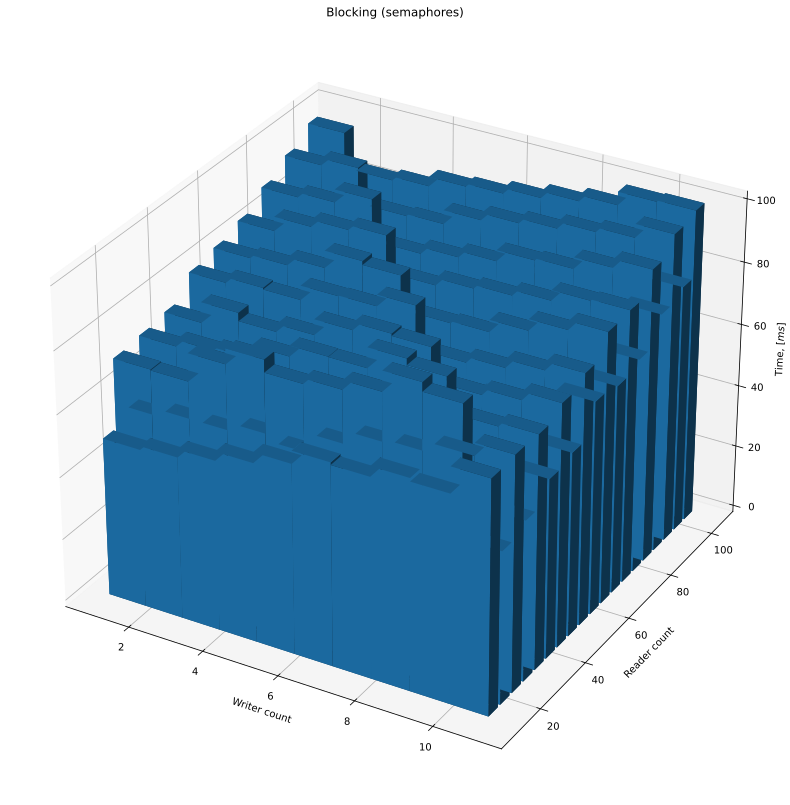

In [13]:
show_plot(blocking, "Blocking (semaphores)")

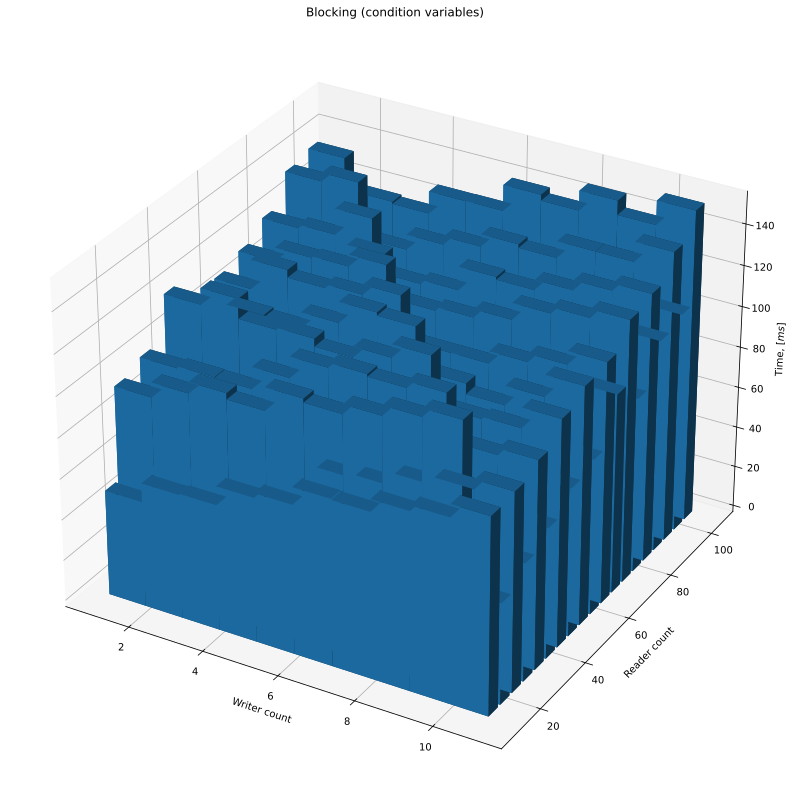

In [14]:
show_plot(blocking_cond, "Blocking (condition variables)")

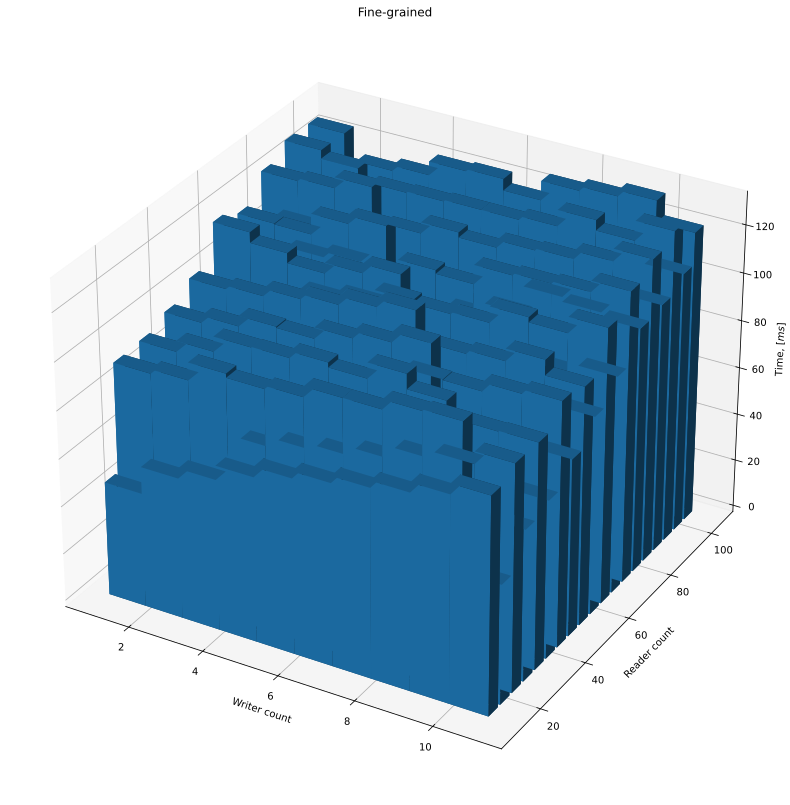

In [15]:
show_plot(finegrained, "Fine-grained")

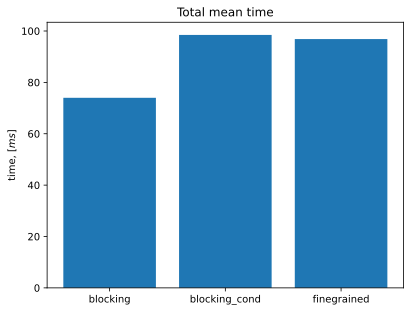

In [16]:
plt.bar(
    ["blocking", "blocking_cond", "finegrained"],
    [blocking_mean, blocking_cond_mean, finegrained_mean]
)
plt.title("Total mean time")
plt.ylabel("time, $[ms]$")
plt.show()

# Wnioski

## Wyniki

- Jak widać z powyższych wykresów, we wszystkich trzech przypadkach czas wykonania rośnie podobnie

- Zgodnie z otrzymanymi wynikami, najmniejszy średni czas wykonania (a więc i najlepszy wynik) ma rozwiązanie
  korzystające z jednego zamku. Tak dobry wynik został osiągnięty tylko z powodu implementacji czytelników i
  pisarzy w klasie `Main`:

  - Czytelnik iteruje po wszystkich rekordach bazy danych
  - Pisarz dodaje dokładnie jeden element
  
  Taka implementacja sprawia, że rozwiązanie z jednym zamkiem będzie rzeczywiście najszybsze, bo wykonuje o wiele
  mniej locków/unlocków w porównaniu z metodą `finegrained`

- Rozwiązanie `blocking_cond` okazało się najmniej wydajne, co jest powiązane z użytymi mechanizmami,
  a mianowicie zmiennymi warunkowymi i metody `signalAll`, która obudza wszystkie czekające wątki

## Uwagi

- Aby osiągnąć bardziej wiarygodne wyniki, należałoby przygotować więcej przypadków testowych, np.:
  - odczytywanie pewnej (stosunkowo małej) liczby rekordów, a nie wszystkich naraz
  - zapis kilku rekordów naraz w randomowych pozycjach
  - usuwanie randomowych wartości, a nie tylko z początku (końca)
- Należałoby mądrzej przetwarzać wyjątki
- Nalezałoby wykonać również pomiary dla większej liczby pisarzy

## Podsumowanie

- **Problem czytelników i pisarzy** – klasyczny informatyczny problem synchronizacji dostępu do jednego zasobu
  (pliku, rekordu bazy danych) dwóch rodzajów procesów: dokonujących i niedokonujących w nim zmian
- Problem został rozwiązany na 3 różne sposoby:
  1. Rozwiązanie **z jednym zamkiem** zaimplementowane **korzystając z semaforów** (`blocking`)
  2. Rozwiązanie **z jednym zamkiem** zaimplementowane **korzystając ze zmiennych warunkowych** (`blocking_cond`)
  3. Rozwiązanie zaimplementowane w oparciu o **blokowanie drobnoziarniste** (`finegrained`)

# Bibliografia

1. Materiały do laboratorium, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab6/](https://home.agh.edu.pl/~funika/tw/lab6/)

2. Readers-writers problem, Wikipedia:\
   [https://en.wikipedia.org/wiki/Readers–writers_problem](https://en.wikipedia.org/wiki/Readers–writers_problem)

3. Problem czytelników i pisarzy, Wikipedia:\
   [https://pl.wikipedia.org/wiki/Problem_czytelników_i_pisarzy](https://pl.wikipedia.org/wiki/Problem_czytelników_i_pisarzy)

4. Structural patterns: Proxy, Refactoring Guru:\
   [https://refactoring.guru/design-patterns/proxy](https://refactoring.guru/design-patterns/proxy)

5. `Condition`, Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/locks/Condition.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/locks/Condition.html)

6. `ReentrantLock`, Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/locks/ReentrantLock.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/locks/ReentrantLock.html)

7. `Semaphore`, Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/Semaphore.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/Semaphore.html)

8. Data Locking, Oracle Docs:\
   [https://docs.oracle.com/cd/E19253-01/816-5137/guide-5/index.html](https://docs.oracle.com/cd/E19253-01/816-5137/guide-5/index.html)